<a href="https://colab.research.google.com/github/fechinmitchell/CMC_GAA_STATS/blob/main/expected_points_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best CV score: 0.9989583333333332
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       140

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



<ipython-input-49-f349140d19ad>:109: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


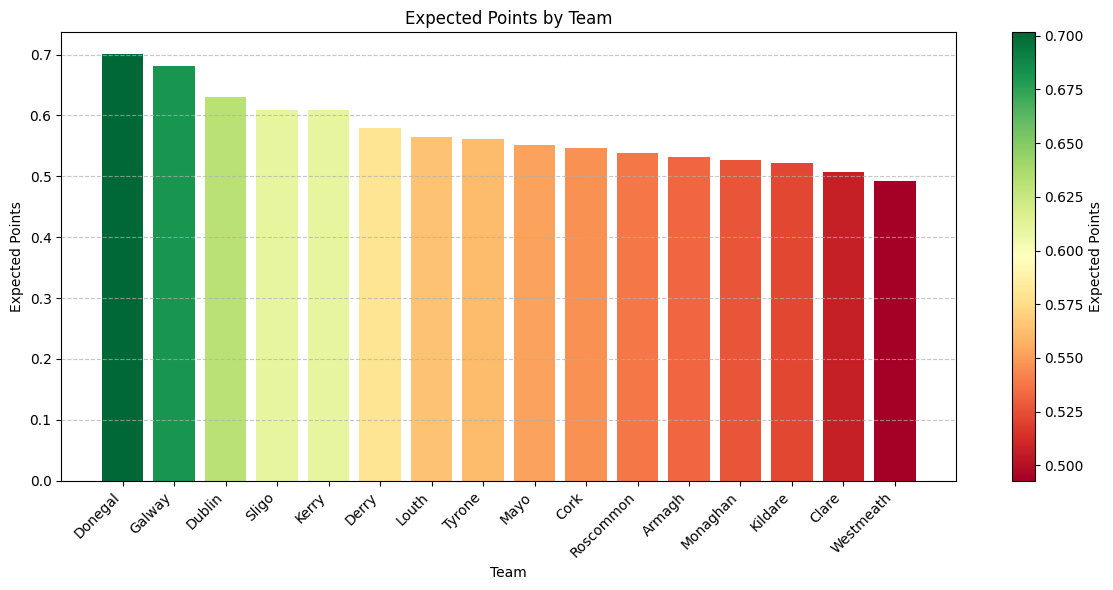


Teams with the Expected Points:
 TeamName
Donegal      0.701524
Galway       0.681154
Dublin       0.630800
Sligo        0.609726
Kerry        0.609713
Derry        0.579795
Louth        0.564583
Tyrone       0.560666
Mayo         0.551708
Cork         0.546017
Roscommon    0.537909
Armagh       0.532587
Monaghan     0.526700
Kildare      0.521942
Clare        0.507176
Westmeath    0.492888
Name: Expected_Points, dtype: float64


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load your dataset
df = pd.read_excel('/content/Football_Championship_2023_Shots.xlsx')

# Assuming specific goal dimensions (modify these as per your dataset's specifics)
goal_line_x = 145  # Example: goal line x-coordinate
goal_width = 7.32  # Standard goal width in meters

# Define the function to calculate the shot angle
def calculate_shot_angle(x, y, goal_line_x, goal_width):
    goal_center_y = goal_width / 2
    adj = goal_line_x - x
    opp = abs(y - goal_center_y)
    angle_rad = np.arctan(opp / adj)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

# Define the function to encode pressure
def encode_pressure(pressure):
    return 1 if pressure == 'y' else 0

# Define the scoring zone
GOAL_LINE = 145  # The goal line's x-coordinate
SCORING_ZONE_DEPTH = 32  # The depth of the scoring zone from the goal line
CENTER_WIDTH = 44  # The center of the pitch width-wise
SCORING_ZONE_HALF_WIDTH = 28  # Half the width of the scoring zone

# Function to check if a shot is within the scoring zone
def is_within_scoring_zone(x, y):
    return (GOAL_LINE - SCORING_ZONE_DEPTH) <= x <= GOAL_LINE and \
           (CENTER_WIDTH - SCORING_ZONE_HALF_WIDTH) <= y <= (CENTER_WIDTH + SCORING_ZONE_HALF_WIDTH)

# Apply the shot angle calculation, encoding of pressure, and scoring zone calculation to the dataframe
df['Shot_Angle'] = df.apply(lambda row: calculate_shot_angle(row['x'], row['y'], goal_line_x, goal_width), axis=1)
df['Pressure_Encoded'] = df['Pressure'].apply(encode_pressure)
df['Is_Scoring_Zone'] = df.apply(lambda row: is_within_scoring_zone(row['x'], row['y']), axis=1)

# Convert 'Score' to binary for classification (0 for Miss, 1 for Score)
df['Score'] = df['Score'].apply(lambda x: 1 if x == 'Score' else 0)

# Preprocessing setup
numeric_features = ['Shot_Distance', 'x', 'y', 'Shot_Angle']
categorical_features = ['Position', 'Foot', 'Pressure_Encoded', 'Action', 'Is_Scoring_Zone']  # Include Is_Scoring_Zone
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipeline setup with StandardScaler
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  # Add StandardScaler with mean=False
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define features and target
X = df.drop(['Score', 'TeamName', 'PlayerName', 'Date', 'Game', 'Pressure'], axis=1)  # Remove 'Pressure' column
y = df['Score']

# Split the dataset with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Add stratify=y

# Grid search for parameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 15]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Predictions and model evaluation
predictions = grid_search.predict(X_test)
print("Classification Report:\n", classification_report(y_test, predictions))

# Calculate the probabilities for each shot using the best model
predictions_proba = grid_search.best_estimator_.predict_proba(X)[:, 1]

# Add the expected points to the DataFrame
df['Expected_Points'] = predictions_proba

# Aggregating Expected Points at the Team and Player Levels
team_ep = df.groupby('TeamName')['Expected_Points'].mean().sort_values(ascending=False)

# Plotting the expected points for each team with a color gradient from green to red
plt.figure(figsize=(12, 6))
norm = Normalize(vmin=min(team_ep), vmax=max(team_ep))
colors = [plt.cm.RdYlGn(norm(value)) for value in team_ep]
bars = plt.bar(team_ep.index, team_ep, color=colors)

# Adding color bar for reference
sm = ScalarMappable(cmap=plt.cm.RdYlGn, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Expected Points')

# Customizing the plot
plt.title('Expected Points by Team')
plt.xlabel('Team')
plt.ylabel('Expected Points')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# List of top 5 and bottom 5 teams based on expected points
top_teams = team_ep.head(16)

print("\nTeams with the Expected Points:\n", top_teams)
